In [1]:
library(OmnipathR)
# library(nichenetr)
library(tidyverse)
library(dplyr)
library(VennDiagram)
library(ggplot2)
library(utils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: grid

Loading required package: futile.logger



```import_ligrecextra_interactions```

link: to documentation <https://r.omnipathdb.org/reference/import_ligrecextra_interactions.html>

This LR dataset contains ligand-receptor interactions without literature reference. The ligand-receptor interactions supported by literature references are part of the `omnipath` dataset.


Default params(without filtering resources) has 8350 edges. The table includes columns as follows. 

'source' 'target' 'source_genesymbol' 'target_genesymbol' 'is_directed' 'is_stimulation' 'is_inhibition' 'consensus_direction' 'consensus_stimulation' 'consensus_inhibition' 'sources' 'references' 'curation_effort' 'n_references' 'n_resources'

**The consensus score is if resources supporting the classification of an entity into a category based on combined information of many resources.**

<span style="color:red">I do not undertand how it can have sources but no references.</span>

| sources                                                         | ref | cur_effort | n_ref | n_source |
|-----------------------------------------------------------------|-----|------------|-------|----------|
|      Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019 | NA  | 0          | 0     | 3        |
| Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019;Wang | NA  | 0          | 0     | 4        |
|                                                                 |     |            |       |          |

In [2]:
# https://r.omnipathdb.org/reference/curated_ligand_receptor_interactions.html
# curated=curated_ligand_receptor_interactions()
lr <- import_ligrecextra_interactions()

In [3]:
lr <- lr %>% filter(!duplicated(lr[, c("source_genesymbol", "target_genesymbol")]))

```import_omnipath_intercell``` Imports the OmniPath intercellular **communication role annotation** database. It provides information on the roles in inter-cellular signaling. E.g. if a protein is a ligand, a receptor, an extracellular matrix (ECM) component, etc.

In [4]:
anno <- import_omnipath_intercell()
anno_raw <- import_omnipath_intercell()
anno_lig <- anno_raw %>%
    dplyr::filter(category %in% c("receptor","ligand"))
# Drop rows where the values in the "parent", "database", and "uniprot" columns are duplicated
anno_raw <- anno_raw %>% filter(!duplicated(anno_raw[, c("parent", "database", "uniprot")]))

# Breaking down complexes

In [5]:
#filter only those are in complex
complex <- filter(lr, grepl('COMPLEX', target) | grepl('COMPLEX',source))
complex$source <- sub("COMPLEX:", "", complex$source)
complex$target <- sub("COMPLEX:", "", complex$target)

In [6]:
#complexes are seperated into individual components
components_target <- unique(unlist(strsplit(complex$source_genesymbol,"_")))
components_source <- unique(unlist(strsplit(complex$target_genesymbol,"_")))
components_both <- c(components_target,components_source)
components_both <- unique(components_both)

Below, we produce all the the possible pairs. 

Example: lets assume complex G1_G2_G3 is linked to another complex G4_G5_G6

| c1 | c2 | complex_origin    |
|----|----|-------------------|
| G1 | G2 | G1_G2_G3_G4_G5_G6 |
| G1 | G3 | G1_G2_G3_G4_G5_G6 |
| G1 | G4 | G1_G2_G3_G4_G5_G6 |
| G1 | G5 | G1_G2_G3_G4_G5_G6 |
| G1 | G6 | G1_G2_G3_G4_G5_G6 |
| G2 | G1 | G1_G2_G3_G4_G5_G6 |
| G2 | G3 | G1_G2_G3_G4_G5_G6 |
| .. | .. | G1_G2_G3_G4_G5_G6 |

In [7]:
# Produce all the possbile pairwise pairs

results <- list()

# Loop through each row of the data frame
for (i in 1:nrow(complex)) {
  # Extract the values from the first column
  values1 <- unlist(strsplit(as.character(complex[i, "source_genesymbol"]), "_"))
  # Extract the values from the second column
  values2 <- unlist(strsplit(as.character(complex[i, "target_genesymbol"]), "_"))
  # Keep the original pair
  original <- paste(complex[i, "source_genesymbol"],complex[i, "target_genesymbol"],sep="_")
  # Generate all the pairwise combinations using combn
  pairs <- combn(c(values1, values2), 2)
  pairs <- t(pairs)
  pairs <- cbind(pairs,original)
  # Append the results to the list
  results[[i]] <- as.data.frame(pairs)
    colnames(results[[i]]) = c("source","target","complex_pair")
    row.names(results[[i]]) <- NULL
}

# Bind the results into a single data frame
result_df2 <- as.data.frame(do.call(rbind, results))

# Switch the values in the "col1" and "col2" columns
df1 <- cbind(result_df2[,2], result_df2[,1], result_df2[,3])
colnames(df1) <- names(result_df2)
# Bind the rows into a single data frame
result_df <- rbind(result_df2, df1)


# Drop the self links
result_df <- result_df %>% filter(!duplicated(result_df[, c("source", "target")]))

# View the resulting data frame
str(result_df)

'data.frame':	3272 obs. of  3 variables:
 $ source      : chr  "IL17A" "IL17A" "IL17RA" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "IL17RC" "ITGA8" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" ...


# Annotation of components

The complexes are decomposed into their individual components. The Omnipath Intercell annotation database is imported and used to annotate each component. If at least two databases categorize a component as a ligand or receptor, it is annotated as such. If not, we check other possible categories such as extracellular matrix, secreted, and transmembrane 



In [8]:
#create a df to store annotation
df <- data.frame(genesymbol = character(length(components_both)), score = numeric(length(components_both)), parent = character(length(components_both)), stringsAsFactors = FALSE)

In [9]:
# Check if the components are categorized as ligands or receptors

for (x in 1:length(components_both)) {
#     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
    genename <- components_both[x]
    parent_score <- sort(table(filter(anno_lig, genesymbol==components_both[x])$parent), decreasing = T, na.last = T)[1]
    parent_category <- names(parent_score)
    
    if (is.null(parent_category)) {
      parent_category <- "NA"
      parent_score <- 0
    }
    
    df[x, "genesymbol"] <- genename
    df[x, "score"] <- parent_score
    df[x, "parent"] <- parent_category

#     df$genesymbol[x] <- genename
#     df$score[x] <- parent_score
#     df$parent[x] <- parent_category
}

table(df$parent)


  ligand       NA receptor 
     238       46      198 

In [10]:
# If a component is not classified as a ligand or receptor, we may consider other categories such as 
# extracellular matrix, secreted, and transmembrane.# annotated others such as secreted, ecm etc

df_na <- filter(df, parent=="NA")$genesymbol

for (x in 1:length(df_na)) {
#     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
    genesymbol <- df_na[x]
    parent_score <- sort(table(filter(anno_raw, genesymbol==df_na[x])$parent), decreasing = T, na.last = T)[1]
    parent_category <- names(parent_score)

    df <- df %>% mutate(parent = ifelse(genesymbol == df_na[x], parent_category, parent))
    df <- df %>% mutate(score = ifelse(genesymbol == df_na[x], parent_score, score))

}

table(df$parent)


          ecm        ligand      receptor      secreted transmembrane 
           29           238           198             8             9 

In [11]:
# categorize ecm/secreted as ligand
df$parent <- replace(df$parent, df$parent == "ecm", "ligand")
df$parent <- replace(df$parent, df$parent == "secreted", "ligand")

# Linking 1

We are using the Omnipath intercellular interaction network, which is the largest available network of its kind, to detect interactions rather than make predictions. The creators of the network have noted that it may contain a large number of false positives. Despite this, we are using it in combination with an annotations database to detect interactions. The network has a size of 98,165 edges.

In [12]:
# Import an intercellular interaction network
ic <- import_intercell_network()

In [13]:
# Import All post-translational interactions
pt <- import_post_translational_interactions()

In [14]:
# "Separate the annotated components of complexes based on their type."
ligands <- filter(df, parent=="ligand")
receptors <- filter(df, parent=="receptor")

In [15]:
# Filter the IC network to include only the components of the complexes
ic <- ic %>%
    filter(source_genesymbol %in% ligands$genesymbol) %>%
    filter(target_genesymbol %in% receptors$genesymbol) %>%
    distinct()

In [16]:
# remove duplicated
ic <- ic %>% filter(!duplicated(ic[, c("source_genesymbol", "target_genesymbol")]))

In [17]:
# create the edges
ic$pair <- paste(ic$source_genesymbol, ic$target_genesymbol,sep="_")
result_df$pair=paste(result_df$source, result_df$target,sep="_")

In [18]:
# repeat the above process for the PT database
pt <- pt %>%
    dplyr::filter(source_genesymbol %in% ligands$genesymbol) %>%
    dplyr::filter(target_genesymbol %in% receptors$genesymbol) %>%
    dplyr::distinct()

In [19]:
pt <- pt %>% filter(!duplicated(pt[, c("source_genesymbol", "target_genesymbol")]))

In [20]:
pt$pair=paste(pt$source_genesymbol, pt$target_genesymbol,sep="_")

In [21]:
# The data frame result_df consists of all the pairwise edges, 
# and we are checking if those edges exist in the IC network
complex_edges_in_ic <- result_df %>%
    filter(pair %in% ic$pair)

str(complex_edges_in_ic)

'data.frame':	978 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "NPNT" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "ITGA8" "ITGB1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "NPNT_ITGA8" "NPNT_ITGB1" ...


In [22]:
filter(result_df, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A
IL17RC,IL17A,IL17A_IL17RA_IL17RC,IL17RC_IL17A
IL17RC,IL17RA,IL17A_IL17RA_IL17RC,IL17RC_IL17RA


In [23]:
filter(complex_edges_in_ic, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC


In [24]:
# repeat the previous process for PT
pt_edges <- result_df %>%
    filter(pair %in% pt$pair)

str(pt_edges)

'data.frame':	983 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "NPNT" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "ITGA8" "ITGB1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "NPNT_ITGA8" "NPNT_ITGB1" ...


# Method 2

In [25]:
# Manual detection of edges through annotation
complex_edges_custom_detect <-result_df %>%
    filter(source %in% ligands$genesymbol) %>%
    filter(target %in% receptors$genesymbol) %>%
    distinct()

str(complex_edges_custom_detect)

'data.frame':	1237 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "NPNT" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "ITGA8" "ITGB1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "NPNT_ITGA8" "NPNT_ITGB1" ...


In [26]:
filter(complex_edges_custom_detect, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC


In [27]:
cat("Number of edges that are detected through intercellula network of Omnipath", nrow(complex_edges_in_ic))
cat("\n\nNumber of edges that are detected through annotations", nrow(complex_edges_custom_detect))
cat("\n\nNumber of edges that are detected through post-translational interactions from OmniPath", nrow(pt_edges))

Number of edges that are detected through intercellula network of Omnipath 978

Number of edges that are detected through annotations 1237

Number of edges that are detected through post-translational interactions from OmniPath 983

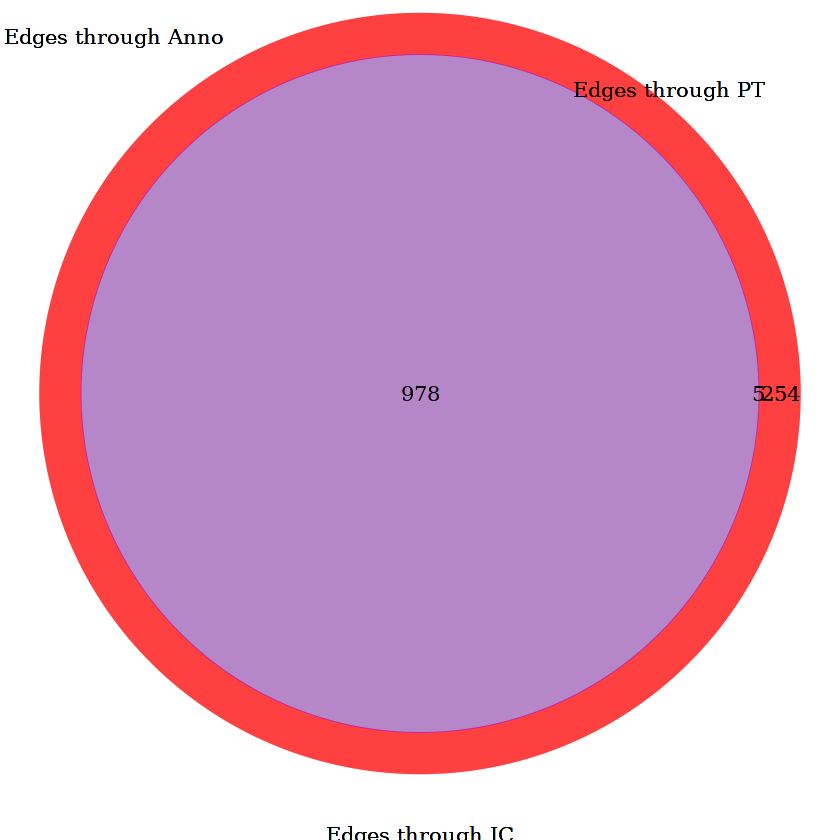

In [28]:
# Lets plot the edges
Venn_plot <- draw.triple.venn(length(complex_edges_in_ic$pair), 
    length(complex_edges_custom_detect$pair), 
    length(pt_edges$pair), 
    n12 = length(intersect(complex_edges_in_ic$pair,
        complex_edges_custom_detect$pair)), 
    n23 = length(intersect(complex_edges_custom_detect$pair, 
        pt_edges$pair)),
    n13 = length(intersect(complex_edges_in_ic$pair, 
        pt_edges$pair)), 
    n123 = length(intersect(dplyr::intersect(complex_edges_in_ic$pair, 
        complex_edges_custom_detect$pair), 
        pt_edges$pair)),
    category = c("Edges through IC", "Edges through Anno",
        "Edges through PT"), 
    lty = rep("blank", 3), fill = c("light blue", "red","purple"), 
    alpha = rep(0.50), euler.d = TRUE, scaled=TRUE)
grid.draw(Venn_plot)

There is a large overlap between the edges detected through. As a result, the triple Euler diagram may not be very useful for visualizing the data. Instead, we will focus on plotting the first set of edges between IC and PT and then after that manual detected one.

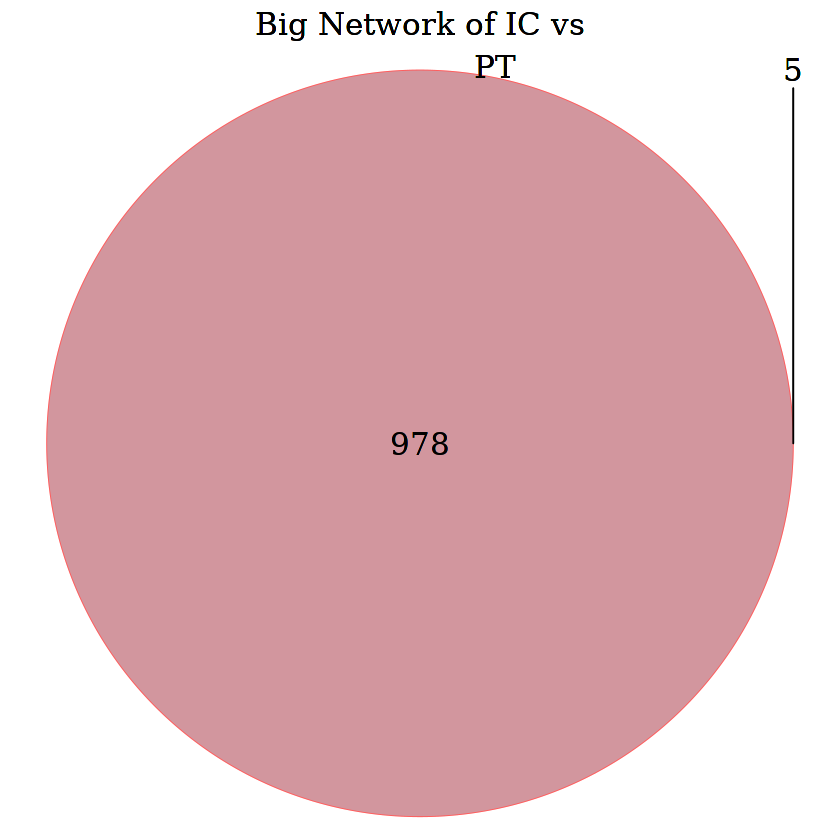

In [29]:
Venn_plot <- draw.pairwise.venn(length(complex_edges_in_ic$pair), 
    length(pt_edges$pair), 
    length(intersect(complex_edges_in_ic$pair,
    pt_edges$pair)), 
    category = c("Big Network of IC vs", "\n\n               PT"), 
    lty = rep("blank", 2), fill = c("light blue", "red"), alpha = rep(0.4, 2), 
    cat.pos = c(0, 0), cat.dist = rep(0.025, 2), cex= 1.5, cat.cex=1.5, 
    verbose = FALSE)
grid.draw(Venn_plot)

Since all the edges in the IC network overlap with the edges detected through the PT and manual methods, 

we will drop the IC network and instead focus on plotting the edges detected through the PT and manual methods.

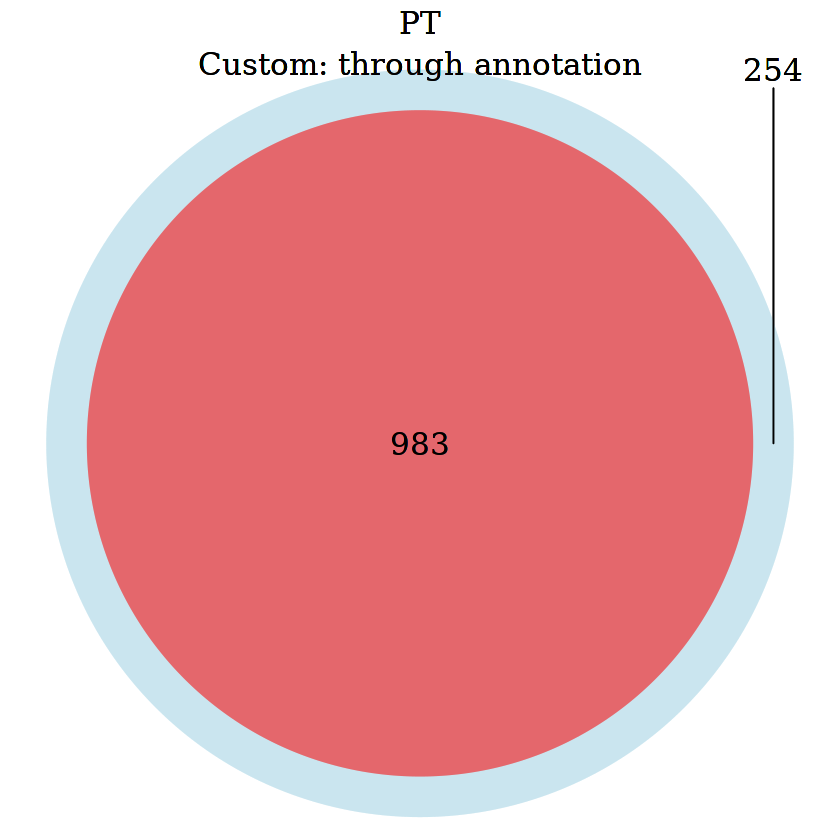

In [30]:
Venn_plot <- draw.pairwise.venn(length(complex_edges_custom_detect$pair), 
    length(pt_edges$pair), 
    length(intersect(complex_edges_custom_detect$pair,
    pt_edges$pair)), 
    category = c("PT", "Custom: through annotation"), 
    lty = rep("blank", 2), fill = c("light blue", "red"), alpha = rep(0.4, 2), 
    cat.pos = c(0, 0), cat.dist = rep(0.025, 2), cex= 1.5, cat.cex=1.5, 
    verbose = FALSE)
grid.draw(Venn_plot)

# Complexes are broken down, now we can combine with the rest of the db

In [31]:
single_components = filter(lr, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))

In [32]:
single_components <- single_components %>%
  select(source_genesymbol, target_genesymbol) %>%
  rename(source=source_genesymbol, target=target_genesymbol) %>%
  mutate(complex_pair = NA)

In [33]:
single_components$pair <- paste(single_components$source, single_components$target, sep="_")

In [34]:
#merge the single ones, with complexes componenets that are detected via PT_DB
complete <- rbind(single_components, pt_edges)

In [35]:
#remove the duplicated ones, and drop the last ones, which are coming from the complexes
complete <- complete[ !duplicated(complete[, "pair"], fromLast=F),]

# Protein Descriptions

In [36]:
library(mygene)

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand



In [37]:
# get gene symbols
gene_symbols <- unique(c(complete$source,complete$target))

In [38]:
prot_descriptions <- queryMany(gene_symbols, scopes = "symbol", 
                              fields = c("name"), 
                              species = "human", as_dataframe = "True")

Querying chunk 1

Querying chunk 2

Querying chunk 3



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [39]:
prot_descriptions <- as.data.frame(prot_descriptions)

In [40]:
#map protein descriptions to complete set

for (x in 1:nrow(complete)) {
    ligand_symbol=complete[x,]$source
    receptor_symbol=complete[x,]$target
    ligand_description=filter(prot_descriptions, query==ligand_symbol)$name
    receptor_description=filter(prot_descriptions, query==receptor_symbol)$name
    
#     if (is.null(ligand_description)) {
#       ligand_description <- "NA"
#     }
    
#     if (is.null(receptor_description)) {
#       receptor_description <- "NA"
#     }
    

    complete[x, "ligand.name"] = ligand_description[1]
    complete[x, "receptor.name"] = receptor_description[1]
}

In [41]:
#reorder columns
complete <- complete[, c("pair", "source", "ligand.name", "target", "receptor.name", "complex_pair")]
#rename column names
names(complete) <- c("Pair.Name", "Ligand", "Ligand.Name", "Receptor", "Receptor.Name", "complex_pair")

In [42]:
head(complete)

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CALM1_TRPC3,CALM1,calmodulin 1,TRPC3,transient receptor potential cation channel subfamily C member 3,NA
S100A10_TRPV6,S100A10,S100 calcium binding protein A10,TRPV6,transient receptor potential cation channel subfamily V member 6,NA
JAK2_EPOR,JAK2,Janus kinase 2,EPOR,erythropoietin receptor,NA
NOTCH1_JAG2,NOTCH1,notch receptor 1,JAG2,jagged canonical Notch ligand 2,NA
JAG2_NOTCH1,JAG2,jagged canonical Notch ligand 2,NOTCH1,notch receptor 1,NA
DLL1_NOTCH1,DLL1,delta like canonical Notch ligand 1,NOTCH1,notch receptor 1,NA


# Comparing with the previous version of the database

In [43]:
# here is the previous version
previous_db <- read.csv("L_R_Database_Maria.csv")

we first compare gene spaces between these two DBs

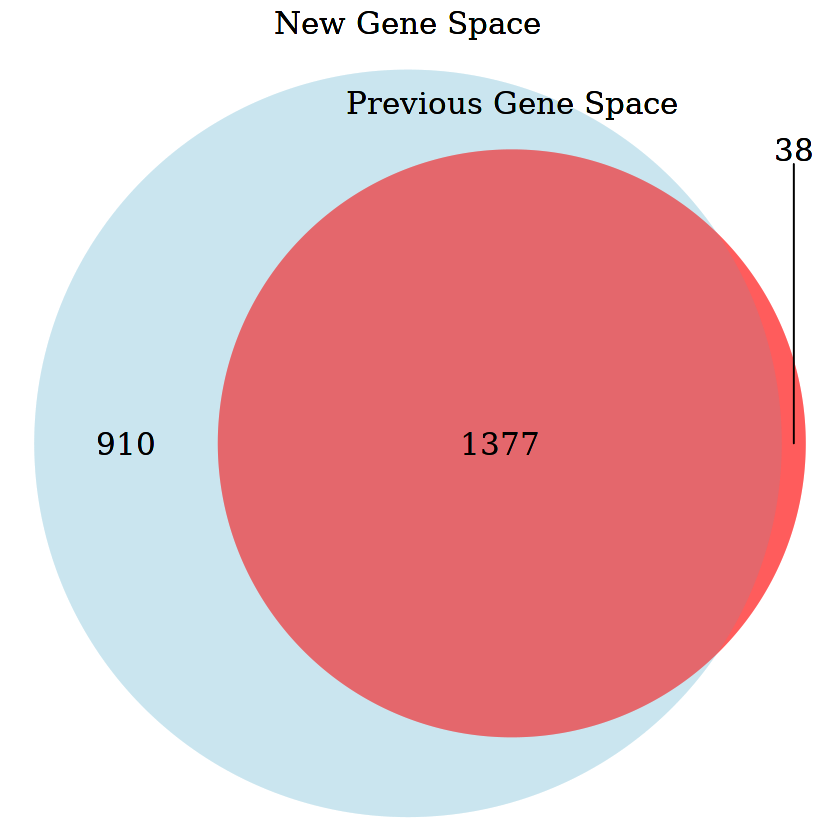

In [44]:
new_gene_space <- unique(c(complete$Ligand,complete$Receptor))
previous_gene_space <- unique(c(previous_db$Ligand,previous_db$Receptor))

Venn_plot <- draw.pairwise.venn(length(new_gene_space), 
    length(previous_gene_space), 
    length(intersect(new_gene_space,
    previous_gene_space)), 
    category = c("New Gene Space", "Previous Gene Space"), 
    lty = rep("blank", 2), fill = c("light blue", "red"), alpha = rep(0.4, 2), 
    cat.pos = c(0, 0), cat.dist = rep(0.025, 2), cex= 1.5, cat.cex=1.5, 
    verbose = FALSE)
grid.draw(Venn_plot)

In [45]:
setdiff(previous_gene_space, new_gene_space)

[1] "AREGB"    "C1orf200" "C4B"      "C5orf55"  "CCL3L3"   "CGB"     
 [7] "CTGF"     "CYR61"    "DEFB103B" "DEFB4A"   "FIGF"     "IFNA13"  
[13] "IL8"      "KAL1"     "MFI2"     "MLLT4"    "NOV"      "YARS"    
[19] "CCL12"    "NGFRAP1"  "HFE2"     "PPAPDC2"  "DARC"     "C14orf1" 
[25] "CD97"     "EMR2"     "ELTD1"    "TMEM8A"   "PVRL1"    "PVRL2"   
[31] "PVRL3"    "PVRL4"    "GPR1"     "BAI2"     "LPHN1"    "LPHN2"   
[37] "GPR56"    NA

The difference is due to the use of different gene symbols. Some of the gene symbols used in the previous database may not be recognized as official or approved gene symbols.

See example below

In [46]:
# In the previous version of the database, the gene symbol LPHN2 was used, 
# which is not an approved gene symbol
filter(previous_db, Receptor=="LPHN2")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,Classification
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SHANK1_LPHN2,SHANK1,SH3 and multiple ankyrin repeat domains 1,LPHN2,latrophilin 2,other


In [47]:
# The approved gene symbol for LPHN2 is ADGRL2. In the current version of the database, 
# we can see that this gene is included and represented using its approved gene symbol
filter(complete, Receptor=="ADGRL2")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SHANK1_ADGRL2,SHANK1,SH3 and multiple ankyrin repeat domains 1,ADGRL2,adhesion G protein-coupled receptor L2,NA
SHANK2_ADGRL2,SHANK2,SH3 and multiple ankyrin repeat domains 2,ADGRL2,adhesion G protein-coupled receptor L2,NA


In [48]:
# Convert the non-approved gene symbols to their approved counterparts

In [49]:
difference <- as.data.frame(setdiff(previous_gene_space, new_gene_space))

In [50]:
colnames(difference) = "previous_name"

In [51]:
approved <- c("AREG",
"PIK3CD-AS1",
"C4B_2",
"EXOC3-AS1",
"CCL3L1",
"CGB8",
"CCN2",
"CCN1",
"DEFB103A",
"DEFB4B",
"VEGFD",
"IFNA1",
"CXCL8",
"ANOS1",
"MELTF",
"AFDN",
"PLXNA1",
"YARS1",
"CCL12_Mouse",
"BEX3",
"HJV",
"PLPP6",
"ACKR1",
"ERG28",
"ADGRE5",
"ADGRE2",
"ADGRL4",
"PGAP6",
"NECTIN1",
"NECTIN2",
"NECTIN3",
"NECTIN4",
"CMKLR2",
"ADGRB2",
"ADGRL1",
"ADGRL2",
"ADGRG1",
"None")

In [52]:
difference$new=approved

In [53]:
replaced_gene_space <- replace(previous_gene_space, 
                               previous_gene_space %in% difference$previous_name, 
                               difference$new)

In [54]:
# lets plot the gene space again

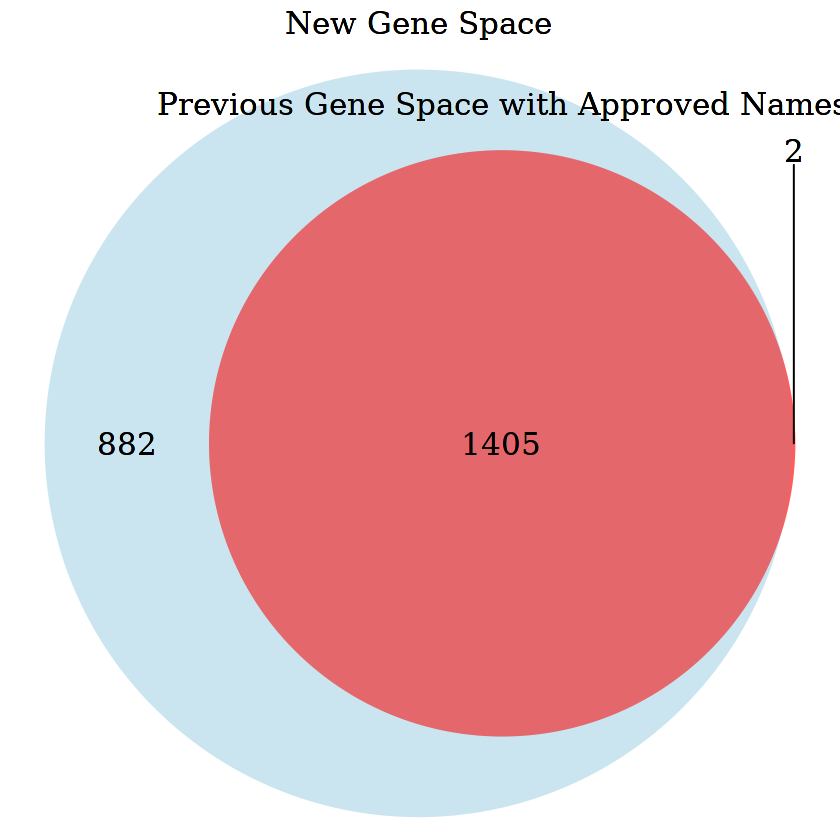

In [55]:
Venn_plot <- draw.pairwise.venn(length(new_gene_space), 
    length(unique(replaced_gene_space)), 
    length(intersect(new_gene_space,
    replaced_gene_space)), 
    category = c("New Gene Space", "Previous Gene Space with Approved Names"), 
    lty = rep("blank", 2), fill = c("light blue", "red"), alpha = rep(0.4, 2), 
    cat.pos = c(0, 0), cat.dist = rep(0.025, 2), cex= 1.5, cat.cex=1.5, 
    verbose = FALSE)
grid.draw(Venn_plot)

In [56]:
setdiff(replaced_gene_space, new_gene_space)

[1] "CCL12_Mouse" "None"

In [57]:
# Comparing Pairs

In [58]:
# Fix the Ligand/Receptor in the previous version of the database by replacing the non-approved gene symbols
# with their approved counterparts

# Loop through the rows of the difference data to replace the previous names with their approved counterparts.
for (i in 1:nrow(difference)) {
  # Check if the Ligand or Receptor values in previous_db are present in the previous value in difference
  ligand_match <- previous_db$Ligand %in% difference$previous_name[i]
  receptor_match <- previous_db$Receptor %in% difference$previous_name[i]
  
  # Update the Ligand and Receptor values in previous_db with the new value in difference if there is a match
  previous_db$Ligand[ligand_match] <- difference$new[i]
  previous_db$Receptor[receptor_match] <- difference$new[i]
}

In [59]:
"AREG" %in% previous_db$Ligand & !"AREGB" %in% previous_db$Ligand

[1] TRUE

In [60]:
# fix the edges with the approved gene symbols in the previous db
previous_db$Pair.Name <- paste(previous_db$Ligand, previous_db$Receptor, sep = "_")

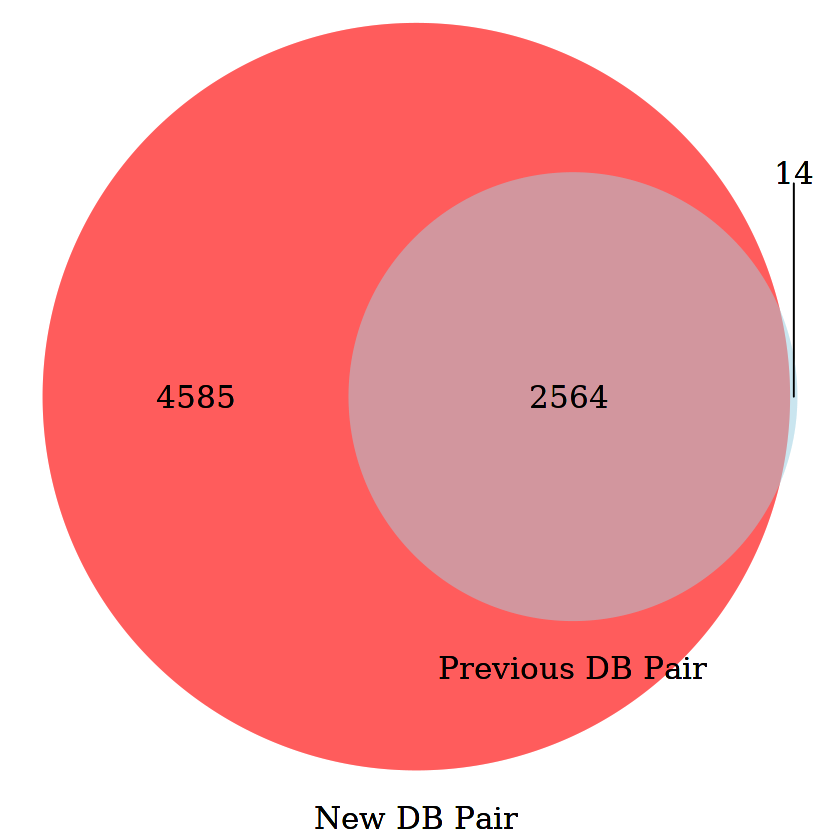

In [61]:
#Finally plot'em

Venn_plot <- draw.pairwise.venn(length(unique(previous_db$Pair.Name)), 
    length(complete$Pair.Name), 
    length(intersect(previous_db$Pair.Name,
    complete$Pair.Name)), 
    category = c("Previous DB Pair", "New DB Pair"), 
    lty = rep("blank", 2), fill = c("light blue", "red"), alpha = rep(0.4, 2), 
    cat.pos = c(0, 0), cat.dist = rep(0.025, 2), cex= 1.5, cat.cex=1.5, 
    verbose = FALSE)
grid.draw(Venn_plot)

In [62]:
setdiff(previous_db$Pair.Name, complete$Pair.Name)

[1] "PLXNA1_PLXNA1"    "CCL12_Mouse_CCR2" "CXCL1_None"       "CXCL5_None"      
 [5] "PPBP_None"        "CCL2_None"        "CCL3_None"        "CCL4_None"       
 [9] "CCL5_None"        "CCL7_None"        "CCL11_None"       "CXCL8_None"      
[13] "CXCL10_None"      "CXCL12_None"

# merge the updated DB with omnipath_original

In [63]:
lr$pair <- paste(lr$source_genesymbol, lr$target_genesymbol, sep="_")

Create a column to merge with. We are doing this because the complex pairs in our data have been broken down, while they are not broken down in the original data. The new column will allow us to match and merge the broken-down pairs with the corresponding pairs in the original data

In [64]:
complete <- complete %>% mutate(to_merge = ifelse(!is.na(complex_pair), complex_pair, paste(Ligand, Receptor, sep="_")))

In [74]:
concatanated <- as.data.frame(merge(complete, lr, by.x = "to_merge", by.y = "pair"))

In [75]:
nrow(complete) == nrow(concatanated)

[1] TRUE

In [81]:
concatanated <- concatanated %>% dplyr::select(-to_merge)

In [82]:
head(concatanated)

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,source_genesymbol,target_genesymbol,⋯,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,LDL receptor related protein 1,NA,P01023,Q07954,A2M,LRP1,⋯,1,0,1,1,0,AlzPathway;Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,AlzPathway:19026743;Baccin2019:10652313;Baccin2019:12194978;Baccin2019:1702392;CellTalkDB:10652313;HPRD:10652313;HPRD:12194978;LRdb:10652313;connectomeDB2020:10652313;connectomeDB2020:12194978;connectomeDB2020:1702392,11,4,11
2,AANAT_MTNR1A,AANAT,aralkylamine N-acetyltransferase,MTNR1A,melatonin receptor 1A,NA,Q16613,P48039,AANAT,MTNR1A,⋯,1,0,1,1,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPMR;HPMR_LRdb;HPMR_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:12943195;CellTalkDB:12943195;HPMR:12943195;LRdb:12943195;connectomeDB2020:12943195,5,1,9
3,AANAT_MTNR1B,AANAT,aralkylamine N-acetyltransferase,MTNR1B,melatonin receptor 1B,NA,Q16613,P49286,AANAT,MTNR1B,⋯,1,0,1,1,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:12943195;CellTalkDB:12943195;LRdb:12943195;connectomeDB2020:12943195,4,1,8
4,ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,ABCA1,SHANK1,⋯,0,0,0,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2
5,ACE_AGTR2,ACE,angiotensin I converting enzyme,AGTR2,angiotensin II receptor type 2,NA,P12821,P50052,ACE,AGTR2,⋯,0,0,0,0,0,Baccin2019;CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;iTALK;talklr,Baccin2019:11459796;HPRD:11459796;LRdb:11459796,3,1,7
6,ACE_BDKRB2,ACE,angiotensin I converting enzyme,BDKRB2,bradykinin receptor B2,NA,P12821,P30411,ACE,BDKRB2,⋯,0,0,0,0,0,Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Lit-BM-17;Ramilowski2015;Ramilowski2015_Baccin2019;connectomeDB2020;iTALK;talklr,Baccin2019:10748135;CellTalkDB:10748135;HPRD:10748135;LRdb:10748135;Lit-BM-17:17077303;connectomeDB2020:10748135,6,2,10


In [83]:
write.csv(concatanated, "L_R_Updated.csv", row.names=FALSE)